## Library

In [1]:
import pandas as pd

from pathlib import Path

import pandas as pd
import plotnine as p9
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import shap


PROJECT_ROOT = Path().cwd().parent.parent
DATA_PATH = PROJECT_ROOT / "data"
EVI_PATH = DATA_PATH / "EVI and Crop Land" / "EVI 2010-2025"
CROPLAND_PATH = DATA_PATH / "EVI and Crop Land" / "Crop Land"
BOUNDARIES_PATH = DATA_PATH / "Shapefiles"

## Functions

In [2]:
def preprocess_evi(evi_file: str | Path) -> pd.DataFrame:
    """Preprocess EVI CSV file."""
    evi_df = pd.read_csv(evi_file)

    metadata_cols = [
        col for col in evi_df.columns if "EVI" not in col and "system:index" not in col
    ]
    evi_df = (
        evi_df.rename(columns=lambda col: col[-14:] if col.endswith("_EVI") else col)
        .drop(columns=["system:index"])
        .melt(
            id_vars=metadata_cols,
            var_name="band_date",
            value_name="EVI",
        )
        .assign(
            date=lambda df: pd.to_datetime(
                df["band_date"].str.extract(r"(\d{4}_\d{2}_\d{2})")[0],
                format="%Y_%m_%d",
            ),
        )
    )
    return evi_df


def clean_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names."""
    df = df.rename(columns=lambda col: col.strip().lower().replace(" ", "_"))
    return df

## Data

In [3]:
gdp_quarterly_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx",
    sheet_name=1,
    skiprows=1,
    skipfooter=1,
)
gdp_adm1_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx", sheet_name=0, skiprows=1
).rename(columns={"Unnamed: 0": "ADM1_NAME"})

evi_adm0_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 0"
                / "MIMU"
                / f"myanmar_adm0_evi_stats_{year}.csv"
            )
            for year in range(2010, 2026)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["date"])
    .reset_index(drop=True)
    .set_index("date")
)
evi_adm1_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 1"
                / "MIMU"
                / f"myanmar_adm1_evi_stats_{year}_batch{batch}.csv"
            )
            for year in range(2010, 2026)
            for batch in range(1, 4)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["ST", "date"])
    .reset_index(drop=True)
    .rename(columns={"ST": "adm1_name"})
    .set_index("date")
)

In [ ]:
ntl_adm0_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm0_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)
ntl_adm1_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm1_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)

ntl_adm0 = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .set_index("date")
    .groupby(pd.Grouper(freq="QS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

ntl_adm1 = (
    ntl_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

In [ ]:
pd.read_csv(DATA_PATH / "AirPollution" / "myanmar_no2_adm3.csv")

In [6]:
adm1_name_map = {
    "Ayeyarwaddy Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magwe Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw Council": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Tanintharyi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def preprocess_bago_and_shan(df: pd.DataFrame) -> pd.DataFrame:
    """Split the values of Bago into two equal parts and Shan into three equal parts."""
    df_bago = df.query("adm1_name == 'Bago'").copy()
    df_bago_new = pd.DataFrame(
        {
            "adm1_name": ["Bago (East)", "Bago (West)"],
            "agriculture": [df_bago["agriculture"].values[0] / 2] * 2,
            "industry": [df_bago["industry"].values[0] / 2] * 2,
            "services": [df_bago["services"].values[0] / 2] * 2,
        }
    )

    df_shan = df.query("adm1_name == 'Shan'").copy()
    df_shan_new = pd.DataFrame(
        {
            "adm1_name": ["Shan (South)", "Shan (East)", "Shan (North)"],
            "agriculture": [df_shan["agriculture"].values[0] / 3] * 3,
            "industry": [df_shan["industry"].values[0] / 3] * 3,
            "services": [df_shan["services"].values[0] / 3] * 3,
        }
    )

    df_rest = df.query("adm1_name not in ['Bago', 'Shan']").copy()

    return pd.concat([df_rest, df_bago_new, df_shan_new], ignore_index=True)


gdp_adm1 = (
    gdp_adm1_raw.pipe(clean_names)
    .assign(adm1_name=lambda df: df["adm1_name"].map(adm1_name_map))
    .pipe(preprocess_bago_and_shan)
    .assign(
        agriculture_pct=lambda df: df["agriculture"] / df["agriculture"].sum(),
        industry_pct=lambda df: df["industry"] / df["industry"].sum(),
        services_pct=lambda df: df["services"] / df["services"].sum(),
    )
)

In [7]:
gdp_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .query('sub_group == "Agriculture" & economic_activity == "Agriculture"')
    .rename(columns={"gdp": "gdp_agri"})
    .filter(["gdp_agri"])
)

evi_adm0 = (
    evi_adm0_raw.groupby(pd.Grouper(freq="QS")).agg({"EVI": "median"}).pipe(clean_names)
)

evi_adm1 = (
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"EVI": "median"})
    .pipe(clean_names)
)

/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_35209/3896827885.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [8]:
gdp_quarterly_adm1 = pd.DataFrame(
    [
        (region, period)
        for region in gdp_adm1["adm1_name"].unique()
        for period in gdp_quarterly.index.unique()
    ],
    columns=["adm1_name", "date"],
)

gdp_quarterly_adm1 = (
    gdp_quarterly_adm1.merge(
        gdp_adm1.filter(["adm1_name", "agriculture_pct"]), on="adm1_name", how="left"
    )
    .merge(gdp_quarterly.reset_index(), on="date", how="left")
    .rename(columns={"gdp_agri": "gdp_agri_total"})
    .assign(gdp_agri=lambda df: df["gdp_agri_total"] * df["agriculture_pct"])
    .set_index(["adm1_name", "date"])
    .filter(["gdp_agri"])
)

## Admin Level 0 Analysis

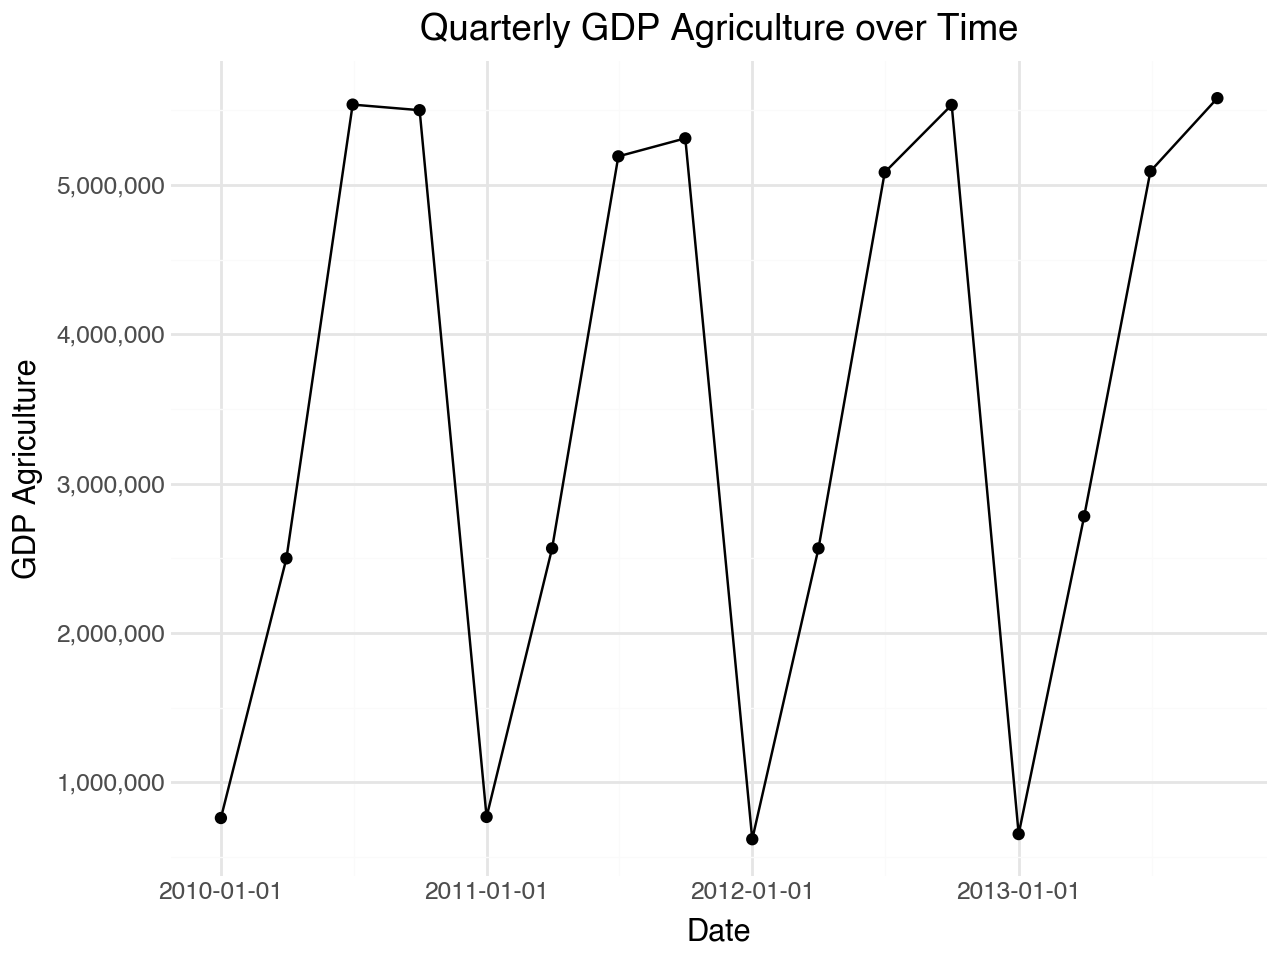

In [9]:
(
    gdp_quarterly.reset_index().query("date <= '2013-12-31'").pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_line()
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Quarterly GDP Agriculture over Time",
        x="Date",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

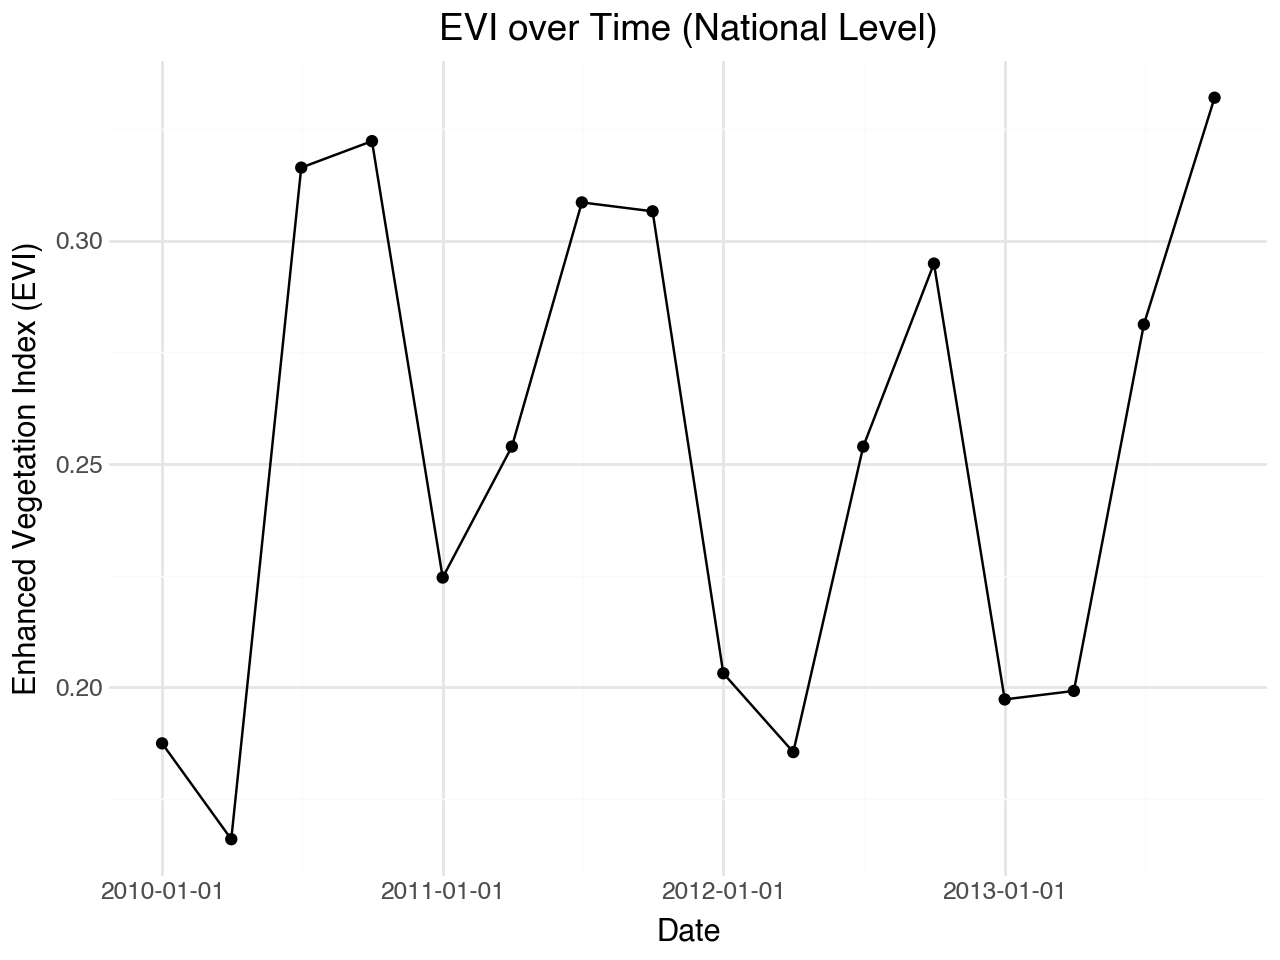

In [10]:
(
    evi_adm0.reset_index().query("date <= '2013-12-31'").pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_point()
    + p9.geom_line()
    + p9.labs(
        title="EVI over Time (National Level)",
        x="Date",
        y="Enhanced Vegetation Index (EVI)",
    )
    + p9.theme_minimal()
)

In [11]:
indicators = (
    gdp_quarterly.join(evi_adm0, how="left")
    .join(ntl_adm0, how="left")
    .assign(
        evi_lag_1=lambda df: df["evi"].shift(1),
        ntl_mean_lag_1=lambda df: df["ntl_mean"].shift(1),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
        evi_lag_1_std=lambda df: StandardScaler().fit_transform(df[["evi_lag_1"]]),
    )
)
indicators.tail()

,gdp_agri,evi,ntl_mean,ntl_sum,evi_lag_1,ntl_mean_lag_1,evi_std,ntl_mean_std,ntl_sum_std,evi_lag_1_std
date,,,,,,,,,,
2023-10-01,3.693112e+06,0.332062,0.094105,9.450224e+05,0.335932,0.118108,1.185745,0.891204,0.931960,1.298006
2024-01-01,6.150236e+05,0.241148,0.082295,1.102821e+06,0.332062,0.094105,-0.403751,0.384744,1.608715,1.229425
2024-04-01,1.836623e+06,0.199210,0.114350,1.085608e+06,0.241148,0.082295,-1.136981,1.759329,1.534892,-0.381889
2024-07-01,3.624389e+06,0.292968,0.130503,1.217865e+06,0.199210,0.114350,0.502245,2.452010,2.102106,-1.125184
2024-10-01,3.434594e+06,0.355467,0.066086,6.640315e+05,0.292968,0.130503,1.594937,-0.310302,-0.273131,0.536542


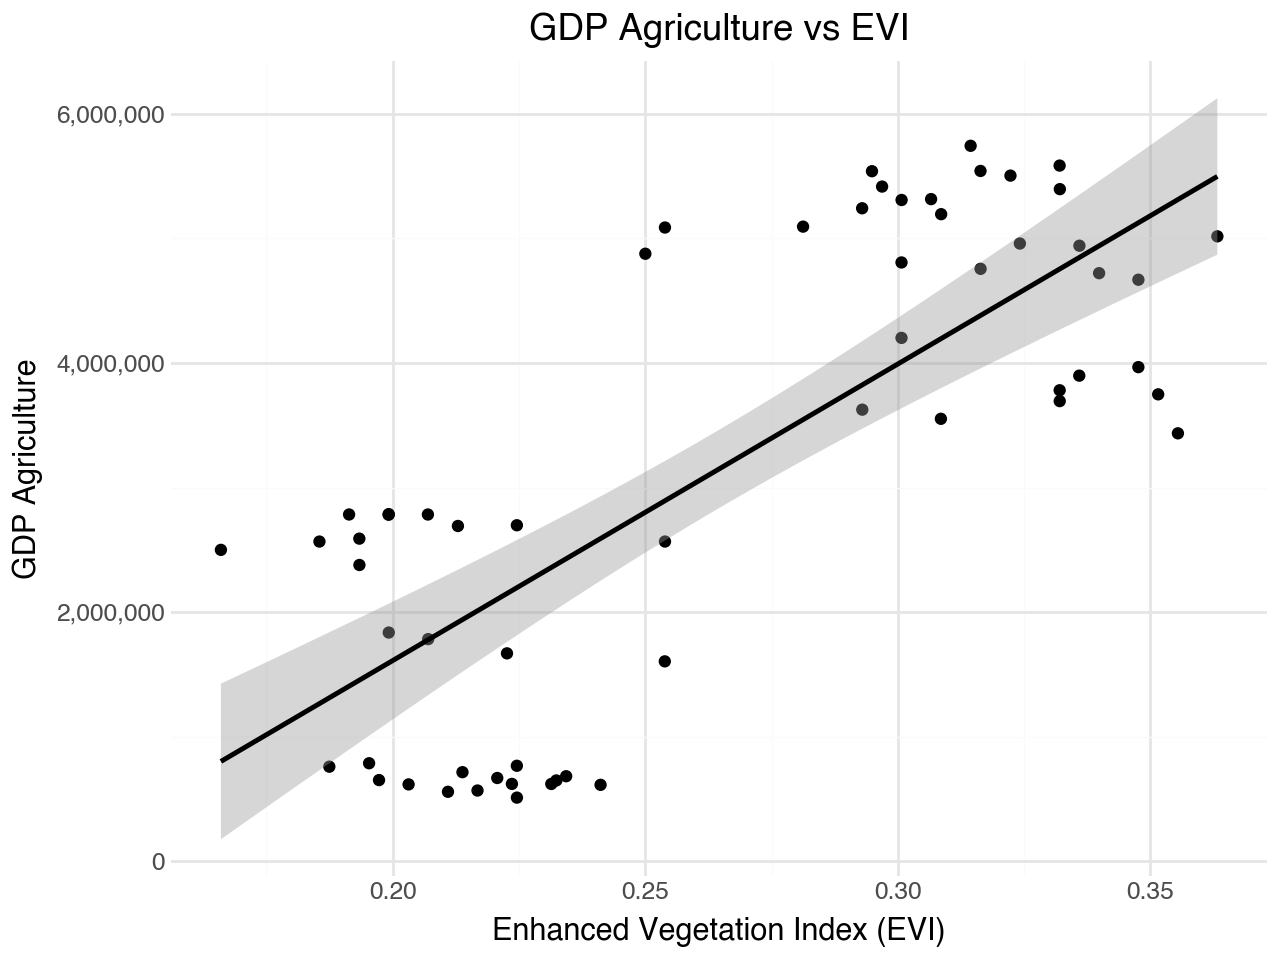

In [12]:
(
    indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 8 rows containing missing values.


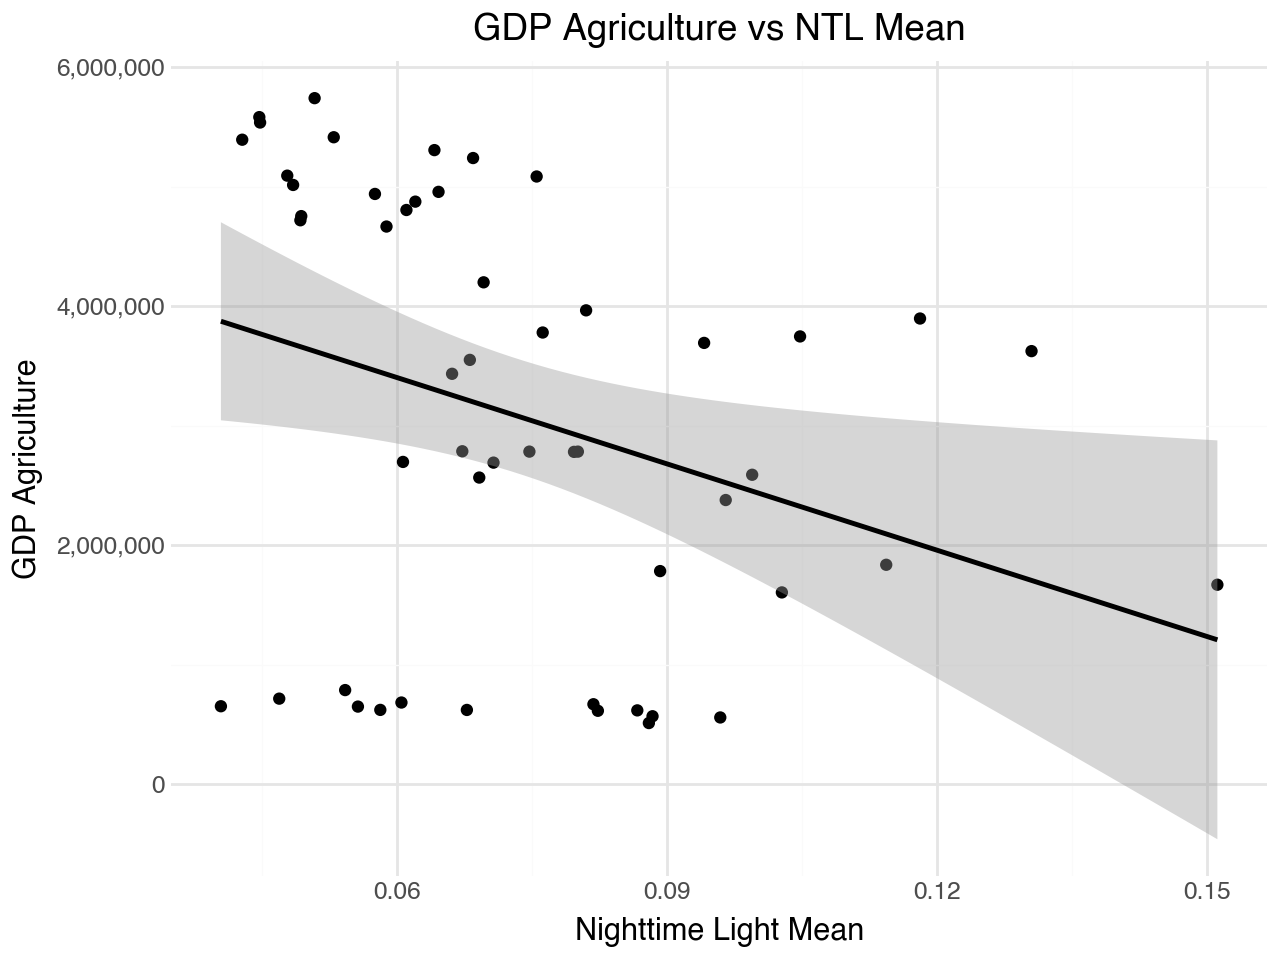

In [13]:
(
    indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_mean", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Mean",
        x="Nighttime Light Mean",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

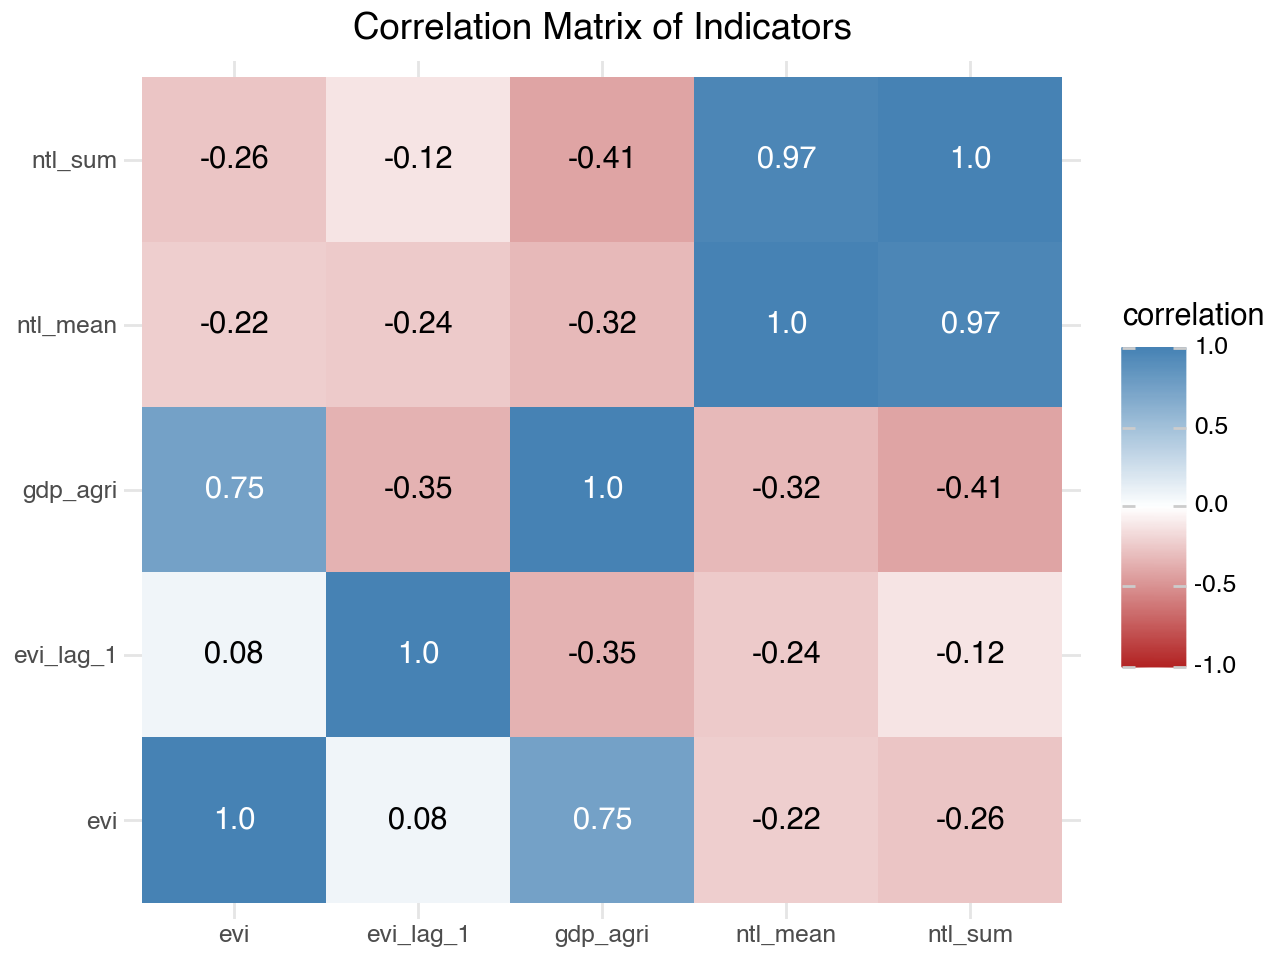

In [14]:
(
    indicators.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of Indicators", x="", y="")
    + p9.theme_minimal()
)

In [15]:
mod_1 = smf.ols("gdp_agri ~ evi", data=indicators).fit()
mod_2 = smf.ols("gdp_agri ~ ntl_mean + evi", data=indicators).fit()
mod_3 = smf.ols("gdp_agri ~ ntl_mean + evi + evi_lag_1", data=indicators).fit()

Stargazer([mod_1, mod_2, mod_3])

In [16]:
mod_4 = smf.ols(
    "gdp_agri ~ ntl_mean_std + evi_std + evi_lag_1_std", data=indicators
).fit()

Stargazer([mod_4])

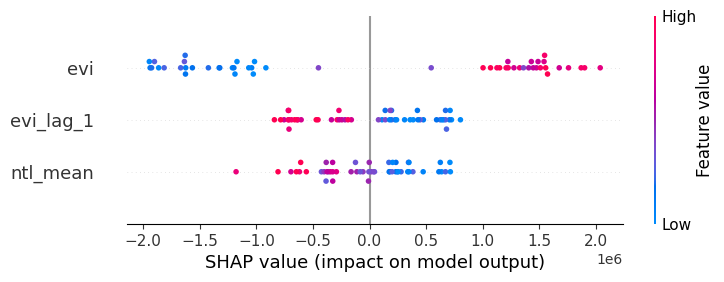

In [27]:
indicators_clean = indicators.dropna()
X = indicators_clean[["evi", "ntl_mean", "evi_lag_1"]]
y = indicators_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

## Admin Level 1 Analysis

In [28]:
indicators_adm1 = (
    gdp_quarterly_adm1.join(evi_adm1, how="left")
    .join(ntl_adm1, how="left")
    .assign(
        gdp_agri_c=lambda df: df["gdp_agri"] - df["gdp_agri"].mean(),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
    )
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            evi_lag_1=df["evi"].shift(1),
            evi_lag_1_std=lambda dff: StandardScaler().fit_transform(
                dff[["evi_lag_1"]]
            ),
            ntl_mean_lag_1=df["ntl_mean"].shift(1),
        ),
    )
    .set_index(["adm1_name", "date"])
)

indicators_adm1.tail()

/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_35209/1422338516.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


gdp_agri       evi  ntl_mean        ntl_sum  \
adm1_name date                                                           
Yangon    2023-10-01  181051.782036  0.271540  1.341484  193872.643026   
          2024-01-01   30151.025456  0.252937  1.288833  248295.662349   
          2024-04-01   90038.926517  0.169862  1.451145  178197.192109   
          2024-07-01  177682.711182  0.285272  1.254324  155936.478288   
          2024-10-01  168378.157293  0.298772  1.215892  175752.381717   

                         gdp_agri_c   evi_std  ntl_mean_std  ntl_sum_std  \
adm1_name date                                                             
Yangon    2023-10-01    6613.860622 -0.310754      4.226818     3.852709   
          2024-01-01 -144286.895958 -0.535517      4.039194     5.219149   
          2024-04-01  -84398.994896 -1.539252      4.617595     3.459133   
          2024-07-01    3244.789768 -0.144840      3.916221     2.900216   
          2024-10-01   -6059.764121  0.018271      3.779268     3.397749   

                      evi_lag_1  evi_lag_1_std  ntl_mean_lag_1  
adm1_name date                                                  
Yangon    2023-10-01   0.308539       0.398672        1.371373  
          2024-01-01   0.271540      -0.067667        1.341484  
          2024-04-01   0.252937      -0.302135        1.288833  
          2024-07-01   0.169862      -1.349206        1.451145  
          2024-10-01   0.285272       0.105410        1.254324

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 24 rows containing missing values.


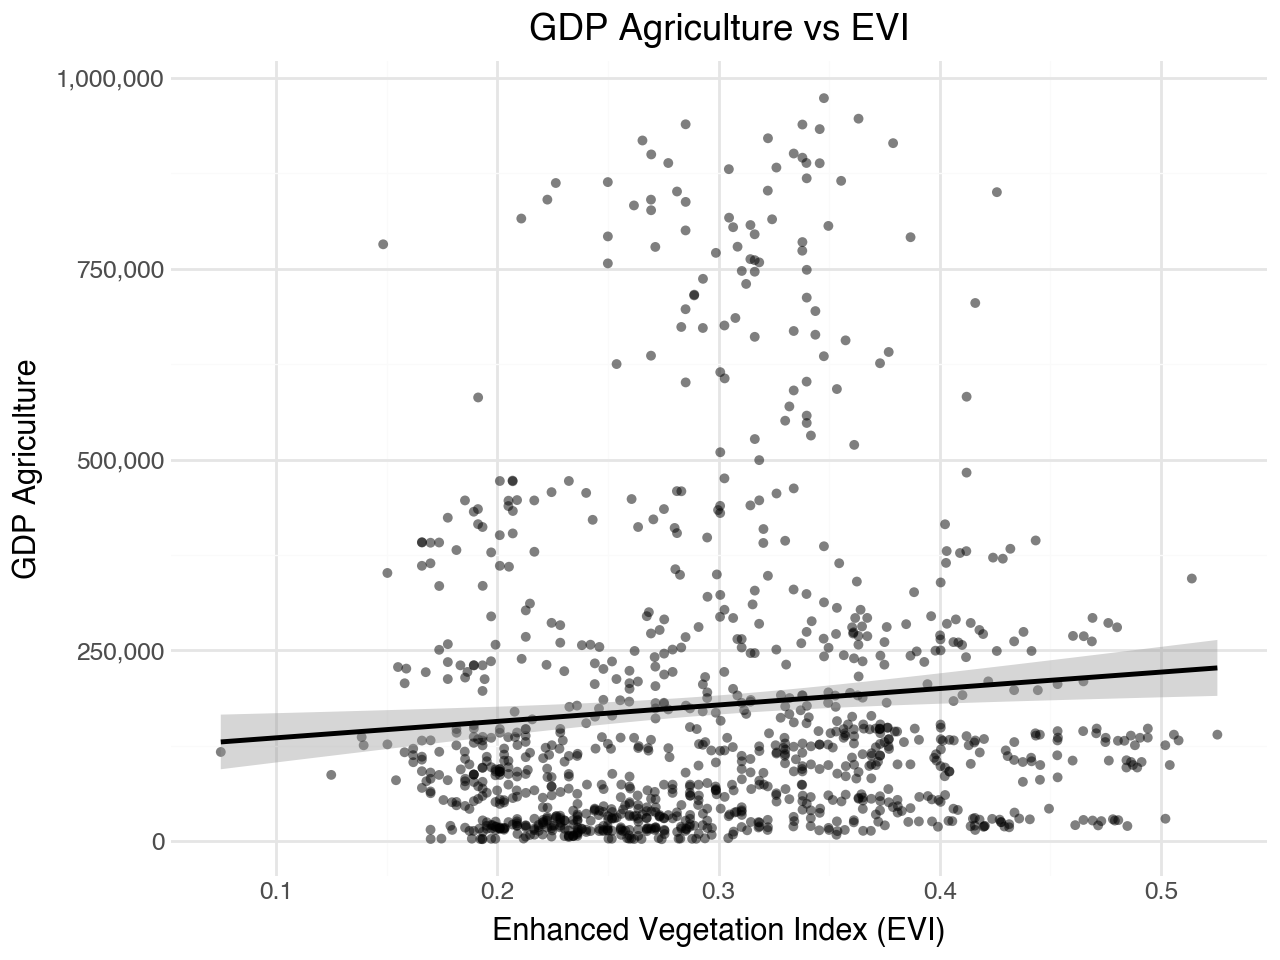

In [29]:
(
    indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

/Users/farhanreynaldo/Documents/world-bank/git-repo/myanmar-economic-monitor/.venv/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 144 rows containing missing values.


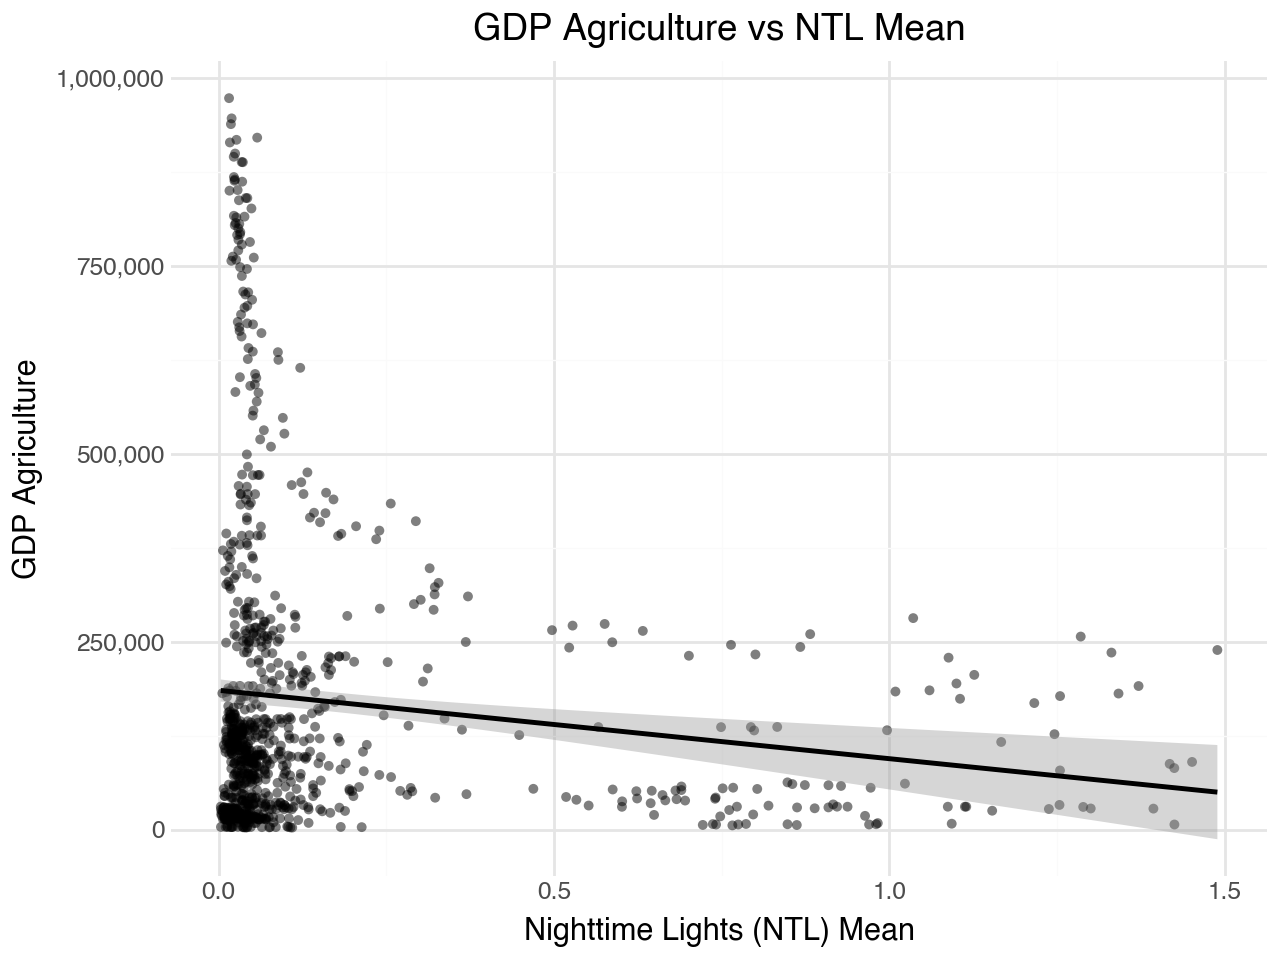

In [30]:
(
    indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_mean", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Mean",
        x="Nighttime Lights (NTL) Mean",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

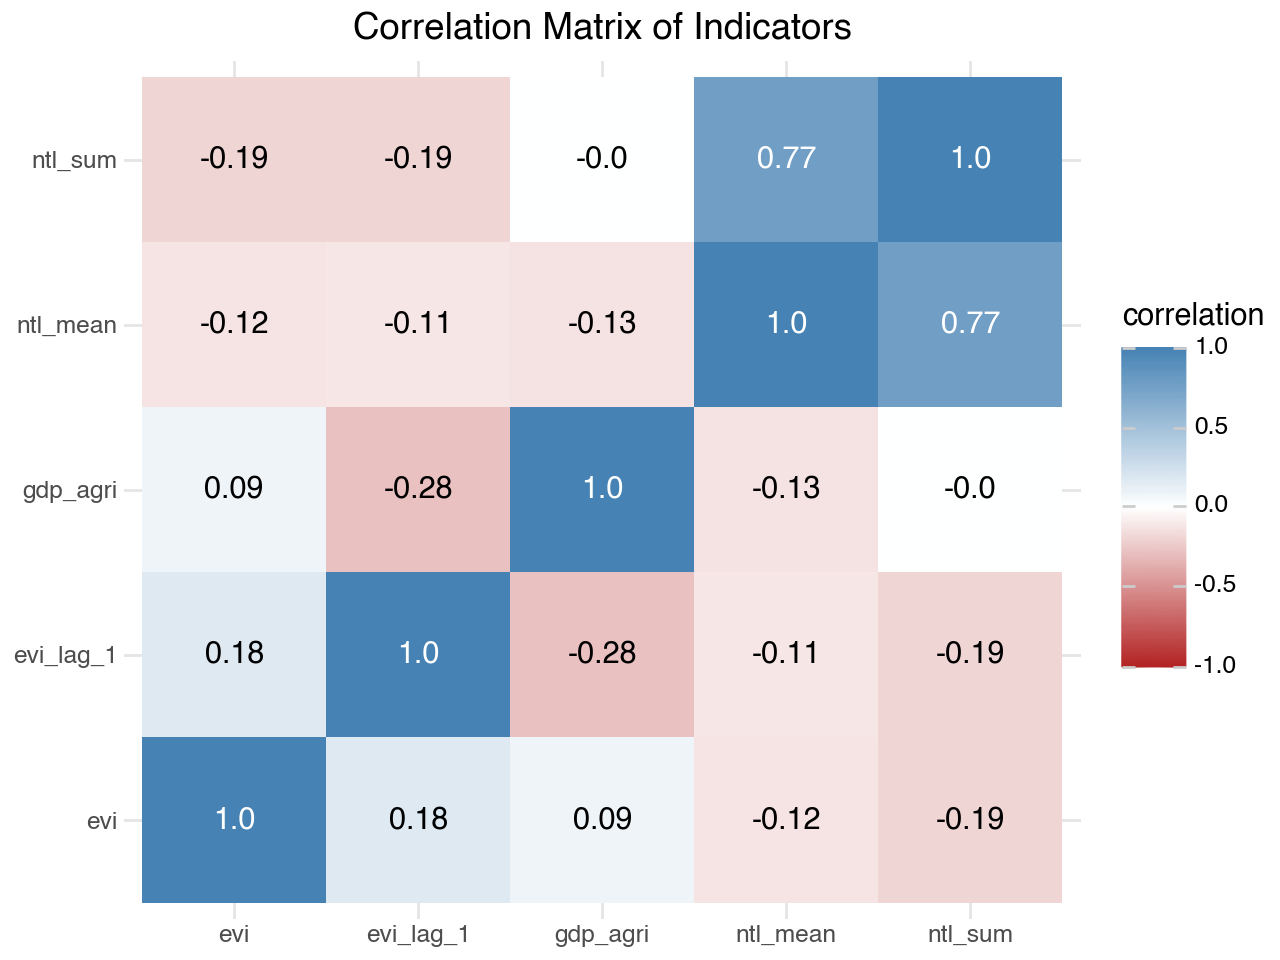

In [31]:
(
    indicators_adm1.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of Indicators", x="", y="")
    + p9.theme_minimal()
)

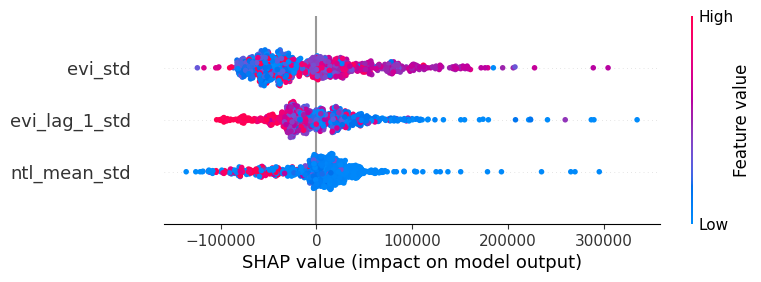

In [32]:
indicators_adm_1_clean = indicators_adm1.dropna()
X = indicators_adm_1_clean[["evi_std", "ntl_mean_std", "evi_lag_1_std"]]
y = indicators_adm_1_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)